In this notebook we determine the magnitude and color based selection of the spectroscopic calibration sample using the `fuji` dataset. We also estimate the $p(z)$ of the ELGs.

Author: Tanveer Karim
Last Updated: November 8 2022

**Note**: This notebook should be run with DESI master kernel. 

In [1]:
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
import healpy as hp 

import sys
sys.path.insert(1, '/global/homes/t/tanveerk/lselgsXplanck/src/')
import utilsAstro

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-paper")

%matplotlib inline

## Import data

### DESI SV3 `fuji` data

In [2]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

#from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask    # For the main survey
#from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV1
#from desitarget.sv2.sv2_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV2
from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV3a

In [3]:
# Release directory path

specprod = 'fuji'
survey_dir = f'/global/cfs/cdirs/desi/spectro/redux/{specprod}'

Read in redshift catalogue

In [4]:
survey = 'sv3'
faprgrm = 'dark' 

zcat = Table.read(f'{survey_dir}/zcatalog/zpix-{survey}-{faprgrm}.fits', hdu="ZCATALOG")

In [5]:
# Targeting information about the DESI targetting is stored in the desi_target columns - 
desi_target = zcat['SV3_DESI_TARGET']

# Masks for different targets
elg_tgtmask = desi_mask['ELG']

### Convert magnitudes and calculate colours for histogram analysis
We will use the 2D histogram on the $g-r$ vs $r-z$ space to decide whether certain cuts cluster in a particular fashion. 

#### Milky Way Transmission for the ELGs
We need to correct the magnitudes for Milky Way dust extinction

In [6]:
from desiutil.dust import mwdust_transmission

In [7]:
len(zcat[(desi_target & elg_tgtmask != 0)])

397288

### Condition for selecting by PHOTSYS

In [8]:
#bands = np.array(['G', 'R', 'Z', 'W1', 'W2'])
bands = np.array(['G', 'R', 'Z'])
is_good_photsys = ~zcat['PHOTSYS'].mask # some photsys are masked
zcat_good_photsys = zcat[is_good_photsys & ((desi_target & elg_tgtmask != 0))]

In [9]:
#mw_transmission_dict = {}

for band in bands:
    #mw_transmission_dict[band] = np.zeros(len(zcat_elg))
    zcat_good_photsys['MW_TRANSMISSION_' + band] = np.zeros(len(zcat_good_photsys))
    for i in range(len(zcat_good_photsys)):
        zcat_good_photsys['MW_TRANSMISSION_' + band][i] = mwdust_transmission(zcat_good_photsys['EBV'][i], band, 
                                                                              zcat_good_photsys['PHOTSYS'][i])

#### Convert nanomaggies to proper magnitude unit

In [10]:
def nmgy2mag(nmgy, ivar=None):
    """
    Name:
        nmgy2mag
    Purpose:
        Convert SDSS nanomaggies to a log10 magnitude.  Also convert
        the inverse variance to mag err if sent.  The basic formulat
        is 
            mag = 22.5-2.5*log_{10}(nanomaggies)
    Calling Sequence:
        mag = nmgy2mag(nmgy)
        mag,err = nmgy2mag(nmgy, ivar=ivar)
    Inputs:
        nmgy: SDSS nanomaggies.  The return value will have the same
            shape as this array.
    Keywords:
        ivar: The inverse variance.  Must have the same shape as nmgy.
            If ivar is sent, then a tuple (mag,err) is returned.
    Outputs:
        The magnitudes.  If ivar= is sent, then a tuple (mag,err)
        is returned.
    Notes:
        The nano-maggie values are clipped to be between 
            [0.001,1.e11]
        which corresponds to a mag range of 30 to -5
    """
    nmgy = np.array(nmgy, ndmin=1, copy=False)

    nmgy_clip = np.clip(nmgy,1e-5,1e11)

    mag = nmgy_clip.copy()
    mag[:] = 22.5-2.5*np.log10(nmgy_clip)

    if ivar is not None:

        ivar = np.array(ivar, ndmin=1, copy=False)
        if ivar.shape != nmgy.shape:
            raise ValueError("ivar must be same shape as input nmgy array")

        err = mag.copy()
        err[:] = np.inf

        w=np.where( ivar > 0 )

        if w[0].size > 0:
            err[w] = np.sqrt(1.0/ivar[w])

            a = 2.5/np.log(10)
            err[w] *= a/nmgy_clip[w]

        return mag, err
    else:
        return mag

In [11]:
for band in bands:
    zcat_good_photsys['MAG_' + band] = nmgy2mag(zcat_good_photsys['FLUX_' + band]/zcat_good_photsys['MW_TRANSMISSION_' + band])

zcat_good_photsys['gfib'] = nmgy2mag(zcat_good_photsys['FIBERFLUX_G']/zcat_good_photsys['MW_TRANSMISSION_G'])
zcat_good_photsys['rfib'] = nmgy2mag(zcat_good_photsys['FIBERFLUX_R']/zcat_good_photsys['MW_TRANSMISSION_R'])
zcat_good_photsys['zfib'] = nmgy2mag(zcat_good_photsys['FIBERFLUX_Z']/zcat_good_photsys['MW_TRANSMISSION_Z'])
zcat_good_photsys['g-r'] = zcat_good_photsys['MAG_G'] - zcat_good_photsys['MAG_R']
zcat_good_photsys['r-z'] = zcat_good_photsys['MAG_R'] - zcat_good_photsys['MAG_Z']

## Does `COADD_FIBERSTATUS` cluster?

In [12]:
range2d = np.array([[0.10, 1.75], [-0.5, .6]])
vmin = 0
vmax = 250
nbins = 100

### Condition for selecting by COADD_FIBERSTATUS

In [13]:
is_coadd_good_photsys = (zcat_good_photsys['COADD_FIBERSTATUS'] == 0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


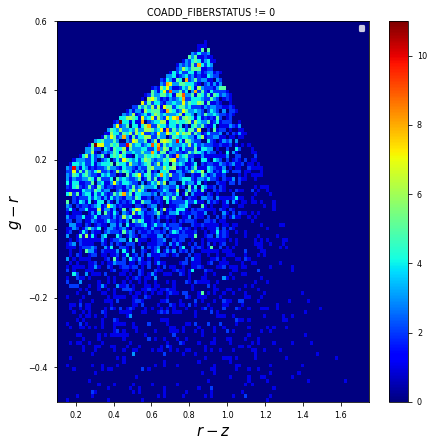

In [14]:
plt.figure(figsize = (7,7))
plt.hist2d(zcat_good_photsys['r-z'][~is_coadd_good_photsys], zcat_good_photsys['g-r'][~is_coadd_good_photsys], 
            bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin);
plt.xlabel(r"$r-z$", fontsize = 15)
plt.ylabel(r"$g-r$", fontsize = 15)
plt.title("COADD_FIBERSTATUS != 0 ")
plt.legend(loc = 'best')
plt.colorbar()

Observation: `COADD_FIBERSTATUS != 0` does not have any particular trend. So we can safely apply this cut. 

### Condition for selecting by ELG bitmask

Next, we apply bitmask values to select ELG targets 

In [15]:
is_elg = (zcat_good_photsys['SV3_DESI_TARGET'] & elg_tgtmask != 0) & is_coadd_good_photsys

zcat_elg = zcat_good_photsys[is_elg]

# Number of sources
n_elg = len(zcat_elg)

print(f'Number of ELGs: {n_elg}')

Number of ELGs: 390901


## When grouped by `MORPHTYPE` what is the redshift distribution and what is the distribution of `SPECTYPE`?

Relevant columns are: `SHAPE_R`, `SHAPE_E1`, `SHAPE_E2`, `SERSIC`

In [16]:
for morph in np.unique(zcat_elg['MORPHTYPE']):
    print(f"% of {morph} is {(zcat_elg['MORPHTYPE'] == morph).sum()/len(zcat_elg['MORPHTYPE']) * 100}")

% of DEV is 2.216929606217431
% of EXP is 7.143240871729671
% of PSF is 37.37288981097516
% of REX is 53.15028613382928
% of SER is 0.11665357724845932


#### Distribution of `SPECTYPE`

In [17]:
for morph in np.unique(zcat_elg['MORPHTYPE']):
    flag = (zcat_elg['MORPHTYPE'] == morph)
    zcat_elg[flag]['SPECTYPE']
    print(f"Morph type: {morph}")
    print("-------")
    for spec in np.unique(zcat_elg[flag]['SPECTYPE']):
        print(f"% of {spec} is {(zcat_elg[flag]['SPECTYPE'] == spec).sum()/len(zcat_elg[flag]['SPECTYPE']) * 100}")
    print("-----")

Morph type: DEV
-------
% of GALAXY is 94.38033694899607
% of QSO is 5.285021924763443
% of STAR is 0.33464112624048004
-----
Morph type: EXP
-------
% of GALAXY is 99.24793181248434
% of QSO is 0.5622605020950471
% of STAR is 0.189807685420621
-----
Morph type: PSF
-------
% of GALAXY is 88.32440054486587
% of QSO is 11.275848614904408
% of STAR is 0.39975084022971985
-----
Morph type: REX
-------
% of GALAXY is 98.8698770245229
% of QSO is 1.081510360262797
% of STAR is 0.04861261521430462
-----
Morph type: SER
-------
% of GALAXY is 87.5
% of QSO is 10.964912280701753
% of STAR is 1.5350877192982455
-----


### Plot: Distribution of redshift

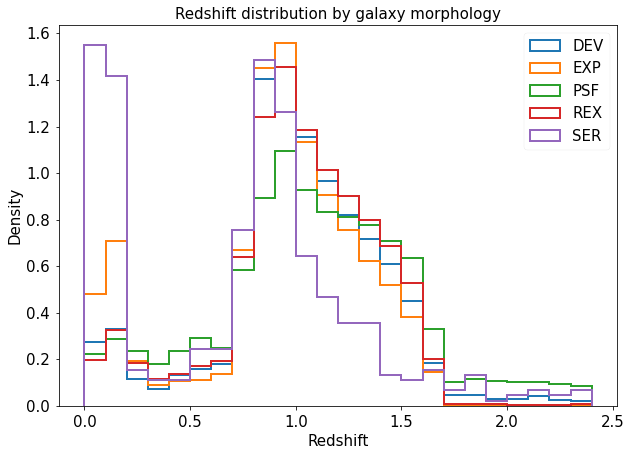

In [18]:
plt.figure(figsize = (10, 7))

for morph in np.unique(zcat_elg['MORPHTYPE']):
    flag = (zcat_elg['MORPHTYPE'] == morph)
    plt.hist(zcat_elg[flag]['Z'], bins = np.arange(0, 2.5, 0.1), histtype= 'step', 
             label = morph, lw = 2, density = True)

plt.title("Redshift distribution by galaxy morphology", fontsize = 15)
plt.ylabel("Density", fontsize = 15)
plt.xlabel("Redshift", fontsize = 15)
plt.legend(loc = 'best', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("../figures/sersic.pdf", dpi = 400, bbox_inches = 'tight')

Observation: We see that Sersic profile targets have a large QSO contamination problem. We clip these because they form only $0.12\%$ of the sample. 

### Condition for removing Sersic galaxies as they are low-z 

In [18]:
is_not_sersic = (zcat_elg['MORPHTYPE'] != 'SER')
zcat_elg = zcat_elg[is_not_sersic]

### Cuts on `SHAPE_R`

We look at whether we can apply cuts based on half-light radii. 

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


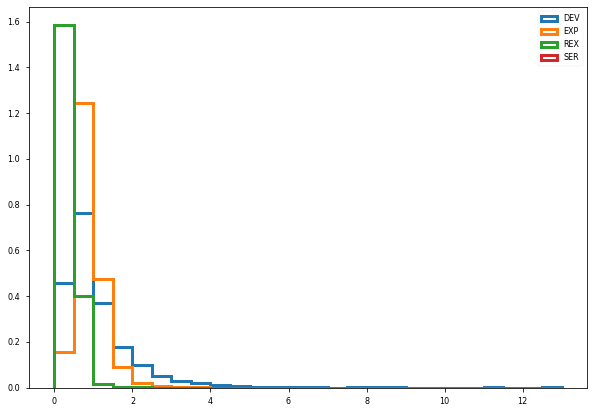

In [20]:
plt.figure(figsize=(10, 7))

for morph in ['DEV', 'EXP', 'REX', 'SER']:
    flag = (zcat_elg['MORPHTYPE'] == morph)
    
    plt.hist(zcat_elg[flag]['SHAPE_R'], bins = np.arange(0, 13.5, .5), label = morph, 
             alpha = 1, lw = 3, histtype = 'step', density = True)

plt.legend(loc = 'best')
plt.show()

Mean of DEV in SHAPE_R: 1.116983413696289
Mean of EXP in SHAPE_R: 0.9024718403816223
Mean of REX in SHAPE_R: 0.4026206433773041


/tmp/ipykernel_56917/1326335268.py:5: RuntimeWarning: Mean of empty slice.
  print(f"Mean of {morph} in SHAPE_R: {zcat_elg[flag]['SHAPE_R'].mean()}")
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Mean of SER in SHAPE_R: nan


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


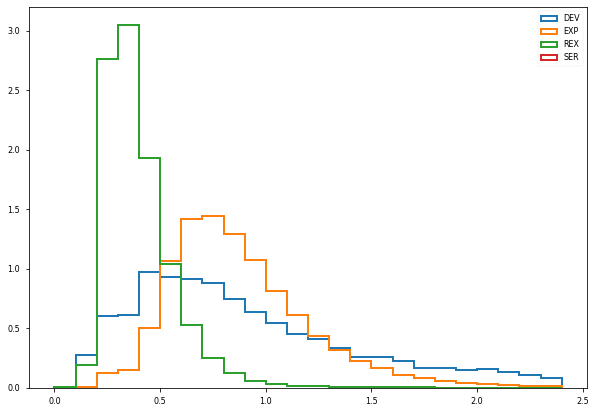

In [19]:
plt.figure(figsize = (10, 7))

for morph in ['DEV', 'EXP', 'REX', 'SER']:
    flag = (zcat_elg['MORPHTYPE'] == morph)
    print(f"Mean of {morph} in SHAPE_R: {zcat_elg[flag]['SHAPE_R'].mean()}")
    plt.hist(zcat_elg[flag]['SHAPE_R'], bins = np.arange(0, 2.5, 0.1), histtype= 'step', 
             label = morph, lw = 2, density = True)
    
plt.legend(loc = 'best')

In [20]:
np.sum(zcat_elg['SHAPE_R'] > 1.5)/len(zcat_elg)

0.01010129467658697

Observation: Only $1\%$ of the samples have `SHAPE_R` > 1.5. We apply this cut to reduce shot noise induced by the samples with a larger `SHAPE_R` value. 

## Does `FOII_SNR` vs `DELTACHI2` cut cluster?

In the ELG target selection paper (Raichoor et al. 2022) it is shown that the spectroscopic redshift reliability rate is a function of `FOII_SNR` and `DELTACHI2`. We apply use this spectroscopic cut to define which targets get the label $2$, i.e., bad. 

### Anand's [OII] flux dataset

We use this dataset to apply the FOII_SNR vs DELTACHI2 cut

In [21]:
# augment [OII] flux for the training galaxies

#relevant emline.fits files generated by Anand Raichoor
from astropy.table import Table, vstack
from glob import glob
fns=sorted(glob("/global/cfs/cdirs/desi/spectro/redux/fuji/healpix/sv3/dark/*/*/emline*fits"))

# those all have unique targetids, and no overlap
e = vstack([Table.read(fn,"EMLINEFIT") for fn in fns], metadata_conflicts="silent")

In [22]:
# check if TARGETID are unique 

def duplicate_test(A):
    return np.any(np.diff(np.sort(A, axis=0), axis=0) == 0)

print(duplicate_test(zcat_elg['TARGETID']))
print(duplicate_test(e['TARGETID']))

False
False


In [23]:
# then match by TARGETID

from desitarget.geomask import match, match_to

is_in_elg_cat = match_to(e['TARGETID'], zcat_elg['TARGETID'])
e_elg = e[is_in_elg_cat]

In [24]:
#verify that the ordering of the sliced Table matches zcat_elg

(zcat_elg['TARGETID']== e_elg['TARGETID']).sum() - len(zcat_elg)

0

In [25]:
#augment zcat_elg table
zcat_elg['OII_FLUX'] = e_elg['OII_FLUX']
zcat_elg['OII_FLUX_IVAR'] = e_elg['OII_FLUX_IVAR']
zcat_elg['OII_SNR'] = zcat_elg['OII_FLUX'] * np.sqrt(zcat_elg['OII_FLUX_IVAR'])
zcat_elg['log10_OII_SNR'] = np.log10(zcat_elg['OII_SNR'])
zcat_elg['log10_DELTACHI2'] = np.log10(zcat_elg['DELTACHI2'])

/tmp/ipykernel_56917/3030149548.py:5: RuntimeWarning: invalid value encountered in log10
  zcat_elg['log10_OII_SNR'] = np.log10(zcat_elg['OII_SNR'])


We then check that the rows are unique in the dataset. 

In [26]:
len(zcat_elg['TARGETID']) == len(np.unique(zcat_elg['TARGETID']))

True

In [27]:
len(zcat['TARGETID']) == len(np.unique(zcat['TARGETID']))

True

If the `TARGETID` were not unique, then the numbers would not be the same as the length of the second array would be smaller. 

## astropy casting issue
Note this interesting situation where converting masked values into numpy casts it as 1. We need to get rid of rows with masked values because these galaxies cannot be used for flux based selection. 

We do not explicitly get rid of them from the training sample because this cut is based on spectroscopic properties. Rather we define the masked values as "bad" galaxies and assign them the label $2$ later on. 

In [29]:
print(zcat_elg['log10_OII_SNR'][(zcat_elg['OII_FLUX'].mask)])
print(np.array(zcat_elg['log10_OII_SNR'][(zcat_elg['OII_FLUX'].mask)]))

log10_OII_SNR
-------------
           --
           --
           --
           --
           --
           --
           --
           --
           --
           --
          ...
           --
           --
           --
           --
           --
           --
           --
           --
           --
           --
           --
Length = 20199 rows
[1. 1. 1. ... 1. 1. 1.]


## Raichoor et al. 2022 cut 

In [28]:
# selection cut of Anand
def oii_sel(x):
    return 0.9 - 0.2 * x
tmpx = np.arange(-1,6, .5)

### OII_FLUX vs DELTACHI2

We check the distribution to define the cut 

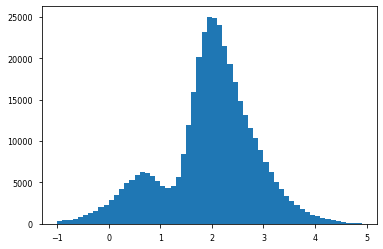

In [31]:
plt.hist(np.log10(zcat_elg['DELTACHI2']), bins = np.arange(-1, 5, .1));

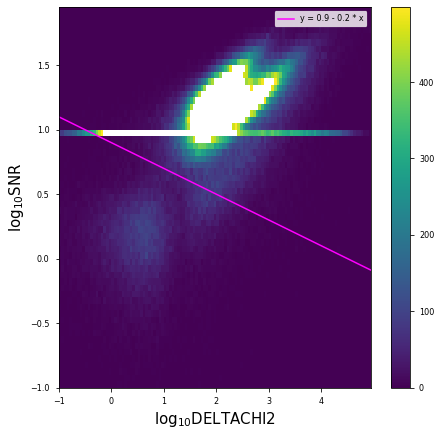

In [32]:
plt.figure(figsize = (7,7))
plt.hist2d(zcat_elg['log10_DELTACHI2'], zcat_elg['log10_OII_SNR'], 
           bins = [np.arange(-1, 5, .05), np.arange(-1,2, .05)], cmax = 500);
plt.plot(tmpx, oii_sel(tmpx), c = 'magenta', lw = 1.5, ls = 'solid', 
          label = 'y = 0.9 - 0.2 * x')
plt.xlabel(r"$\log_{10} {\rm DELTACHI2}$", fontsize = 15)
plt.ylabel(r"$\log_{10} {\rm SNR}$", fontsize = 15)
plt.legend(loc = 'best')
plt.colorbar()

These spurious 1 values are actually astro mask values as described in the previous section. We will explicitly mark these as "bad" galaxies later on. 

## Condition for [O II] flux based cut

In [29]:
is_oii_good = (zcat_elg['log10_OII_SNR']) > oii_sel(zcat_elg['log10_DELTACHI2'])

Note that we need to classify bad regions where QSOs and SPECTYPE STAR cluster (if any)

## FDR cut for plotting purposes

In [30]:
#DEFINE FDR CUT FOR PLOTTING PURPOSES

def fdr_plot(axs):
    #rz 0.15 cut 
    rz3_x = .15 * np.ones(10)
    rz3_y = np.linspace(-.5, .18, 10)
    
    #rz 1.6 cut
    rz16_x = 1.6 * np.ones(100)
    rz16_y = np.linspace(-.5, -.32, 100)
    
    #star/lowz cut
    lowz_x = np.arange(0.15, 15/17, .01)
    #lowzSouth_y = 1.15 * lowz_x -.15
    #lowzNorth_y = 1.15 * lowz_x -.20
    lowz_y = 0.5 * lowz_x + 0.1
    
    # [O II] cut
    OIIx = np.arange(15/17, 1.6, .01)
    OIIy = -1.2 * OIIx + 1.6
       
    axs.plot(rz3_x, rz3_y, c = 'magenta')
    axs.plot(rz16_x, rz16_y, c = 'k')
    axs.plot(OIIx, OIIy, c = 'y', label = '[O II] cut')
    axs.plot(lowz_x, lowz_y, c = 'r', label = 'lowz cut')
    #axs.legend(loc = 'best')

## Statistics of bad ELGs

### Condition for galaxies with no or negative OII fluxes

In [31]:
#define flag for galaxies with no OII flux or negative OII flux
is_bad_flux = zcat_elg['log10_OII_SNR'].mask

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


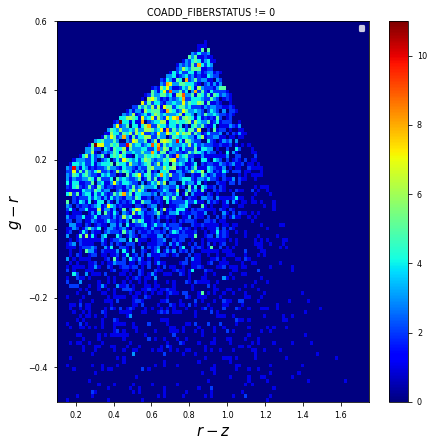

In [32]:
plt.figure(figsize = (7,7))
plt.hist2d(zcat_good_photsys['r-z'][~is_coadd_good_photsys], zcat_good_photsys['g-r'][~is_coadd_good_photsys], 
            bins = 100, cmap = plt.cm.jet, range = range2d, vmin = vmin);
plt.xlabel(r"$r-z$", fontsize = 15)
plt.ylabel(r"$g-r$", fontsize = 15)
plt.title("COADD_FIBERSTATUS != 0 ")
plt.legend(loc = 'best')
plt.colorbar()

Text(0.02, 0.5, 'g-r')

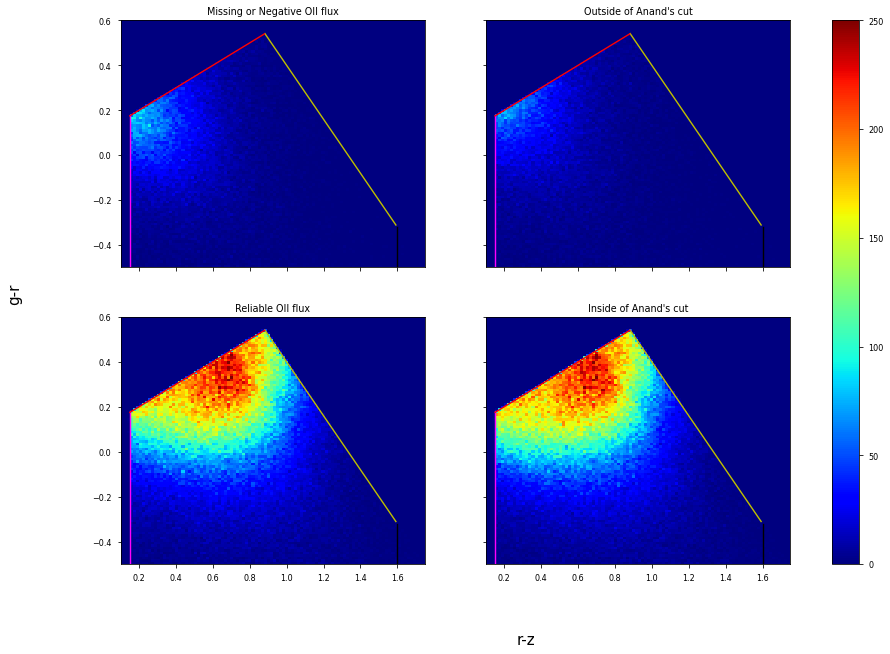

In [37]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (15, 10))

axs[0, 0].hist2d(zcat_elg['r-z'][is_bad_flux], zcat_elg['g-r'][is_bad_flux], 
                 bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,0].set_title("Missing or Negative OII flux")
fdr_plot(axs[0,0])

axs[1,1].hist2d(zcat_elg['r-z'][is_oii_good], zcat_elg['g-r'][is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,1].set_title("Inside of Anand's cut")
fdr_plot(axs[1,1])

axs[1,0].hist2d(zcat_elg['r-z'][~is_bad_flux], zcat_elg['g-r'][~is_bad_flux], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,0].set_title("Reliable OII flux")
fdr_plot(axs[1,0])

im = axs[0,1].hist2d(zcat_elg['r-z'][~is_oii_good], zcat_elg['g-r'][~is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,1].set_title("Outside of Anand's cut")
fdr_plot(axs[0,1])

#add common colorbar
fig.colorbar(im[3], ax=axs.ravel().tolist())

# hide tick and tick label of the big axis
fig.supxlabel('r-z', fontsize = 15)
fig.supylabel('g-r', fontsize = 15)

### Observation
Unreliable OII flux measurements and Anand's cut coincides. But the relative density is low. We have to measure the relative occurance of failure modes in those regions compared to outside. 

## Test 3: Does `SPECTYPE != GALAXY` cluster?

What percentage of misclassified `SPECTYPE` are STAR and QSO?

In [33]:
print(f"frac of QSO: {(zcat_elg['SPECTYPE'] == 'QSO').sum()/len(zcat_elg) * 100}")
print(f"frac of STAR: {(zcat_elg['SPECTYPE'] == 'STAR').sum()/len(zcat_elg) * 100}")

frac of QSO: 4.952041900907939
frac of STAR: 0.19644252071354482


### Condition for SPECTYPE

In [34]:
is_spectype = (zcat_elg['SPECTYPE'] == 'GALAXY')

In [35]:
vmax = 50

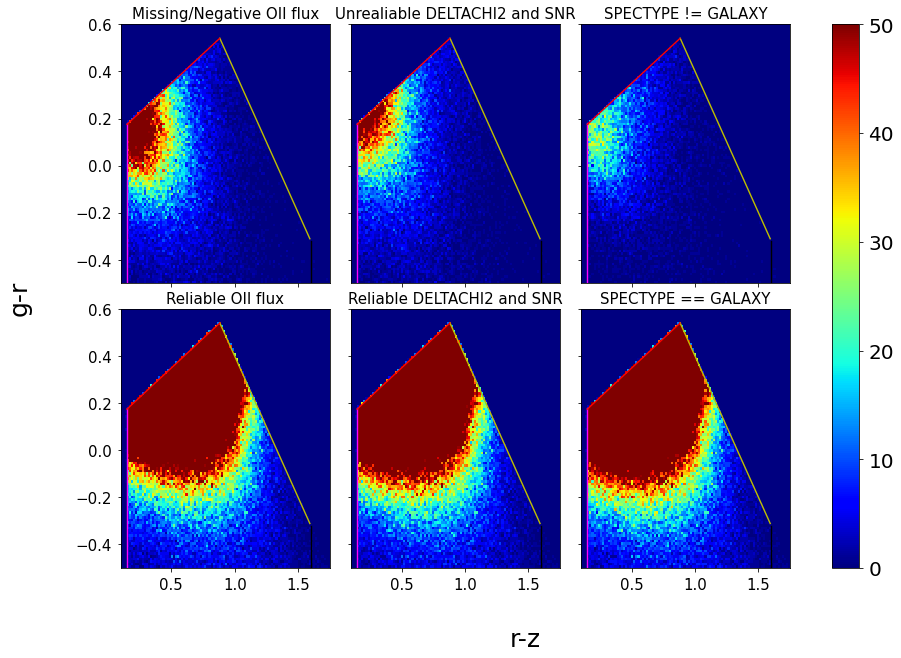

In [56]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axs[0, 0].hist2d(zcat_elg['r-z'][is_bad_flux], zcat_elg['g-r'][is_bad_flux], 
                 bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,0].set_title("Missing/Negative OII flux", fontsize = 15)
fdr_plot(axs[0,0])
#axs[0,0].tick_params(axis='both', which='major', labelsize=15)
#axs[0,0].tick_params(axis='both', which='minor', labelsize=10)

axs[1,1].hist2d(zcat_elg['r-z'][is_oii_good], zcat_elg['g-r'][is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,1].set_title("Reliable DELTACHI2 and SNR", fontsize = 15)
fdr_plot(axs[1,1])
#axs[1,1].tick_params(axis='both', which='major', labelsize=15)
#axs[1,1].tick_params(axis='both', which='minor', labelsize=10)

axs[1,0].hist2d(zcat_elg['r-z'][~is_bad_flux], zcat_elg['g-r'][~is_bad_flux], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,0].set_title("Reliable OII flux", fontsize = 15)
fdr_plot(axs[1,0])
#axs[1,0].tick_params(axis='both', which='major', labelsize=15)
#axs[1,0].tick_params(axis='both', which='minor', labelsize=10)

im = axs[0,1].hist2d(zcat_elg['r-z'][~is_oii_good], zcat_elg['g-r'][~is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,1].set_title("Unrealiable DELTACHI2 and SNR", fontsize = 15)
fdr_plot(axs[0,1])

axs[0,2].hist2d(zcat_elg['r-z'][~is_spectype], zcat_elg['g-r'][~is_spectype], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,2].set_title("SPECTYPE != GALAXY", fontsize = 15)
fdr_plot(axs[0,2])

axs[1,2].hist2d(zcat_elg['r-z'][is_spectype], zcat_elg['g-r'][is_spectype], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,2].set_title("SPECTYPE == GALAXY", fontsize = 15)
fdr_plot(axs[1,2])
#axs[1,2].tick_params(axis='both', which='major', labelsize=15)
#axs[1,2].tick_params(axis='both', which='minor', labelsize=10)

#add common colorbar
cbar = fig.colorbar(im[3], ax=axs.ravel().tolist())

#cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
        
# hide tick and tick label of the big axis
fig.supxlabel('r-z', fontsize = 25)
fig.supylabel('g-r', fontsize = 25)

axs[0,0].tick_params(axis='both', which='major', labelsize=15)
axs[1,0].tick_params(axis='both', which='major', labelsize=15)
axs[1,0].tick_params(axis='both', which='minor', labelsize=10)
axs[1,1].tick_params(axis='both', which='major', labelsize=15)
axs[1,1].tick_params(axis='both', which='minor', labelsize=10)
axs[1,2].tick_params(axis='both', which='major', labelsize=15)
axs[1,2].tick_params(axis='both', which='minor', labelsize=10)


axs[0,0].grid(visible = False)
axs[0,1].grid(visible = False)
axs[0,2].grid(visible = False)
axs[1,0].grid(visible = False)
axs[1,1].grid(visible = False)
axs[1,2].grid(visible = False)

plt.savefig("../figures/clustering_spec_properties.pdf", dpi = 300, bbox_inches = 'tight')

### Observation
Yes they cluster the same way.

## Selection for bad galaxies

These either have missing or negative fluxes

In [44]:
misc_bad_bin_notspec = is_bad_flux | (~(is_oii_good.filled(False))) #bad bin definition except spec type

## $g_{\rm fib}$ cut off and its impact on dndz

We investigate whether a fiber magnitude based cut preferentially selects for ELG targets we desire.

% of SV3 sample discarded due to g_fib threshold: 1.5566853205957305


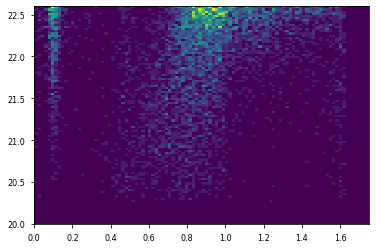

In [46]:
g_fib_threshold = 22.6
tmpsel_fib = (zcat_elg['gfib'] < g_fib_threshold) & (~misc_bad_bin_notspec)
tmpselneg_fib = (zcat_elg['gfib'] >= g_fib_threshold) & (~misc_bad_bin_notspec)

print(f'% of SV3 sample discarded due to g_fib threshold: {tmpsel_fib.sum()/len(tmpsel_fib) * 100}')
plt.hist2d(zcat_elg['Z'][tmpsel_fib], zcat_elg['gfib'][tmpsel_fib], bins = 100, 
           range = np.array([[0, 1.75], [20, g_fib_threshold]]));

Text(0.5, 1.0, 'gfib threshold: 22.6')

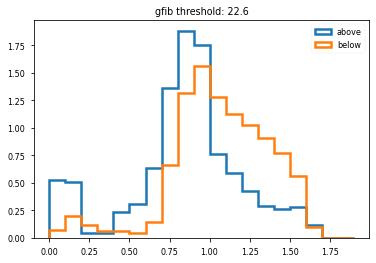

In [47]:
plt.hist(zcat_elg['Z'][tmpsel_fib], bins = np.arange(0, 2, 0.1), histtype= 'step', label = 'above', lw = 2.5, density = True)
plt.hist(zcat_elg['Z'][tmpselneg_fib], bins = np.arange(0, 2, 0.1), histtype= 'step', label = 'below', lw = 2.5, density = True)
plt.legend(loc = 'best')
plt.title(f"gfib threshold: {g_fib_threshold}")

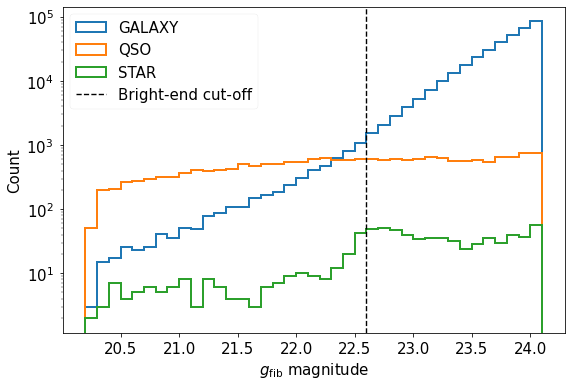

In [53]:
plt.figure(figsize=(9, 6))
for typ in ['GALAXY', 'QSO', 'STAR']:
    tmpflag = (zcat_elg['SPECTYPE'] == typ)# & (~misc_bad_bin_notspec)
    plt.hist(zcat_elg[tmpflag]['gfib'], bins = np.arange(20.2, 24.1, 0.1), label = typ, histtype= 'step',
            lw = 2, density = False)
plt.yscale("log")
plt.axvline(g_fib_threshold, c = 'k', ls = '--', label = 'Bright-end cut-off')
plt.legend(loc = 'upper left', fontsize = 15)
plt.xlabel(r"$g_{\rm fib}$ magnitude", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("../figures/gfib_cut.pdf", bbox_inches = 'tight', dpi = 450)

In [49]:
g_fib_threshold = 22.6
tmpsel_fib = (zcat_elg['gfib'] < g_fib_threshold) #& (~misc_bad_bin_notspec)
tmpselneg_fib = (zcat_elg['gfib'] >= g_fib_threshold) #& (~misc_bad_bin_notspec)

print(f'% of SV3 sample discarded due to g_fib threshold: {tmpsel_fib.sum()/len(tmpsel_fib) * 100}')

% of SV3 sample discarded due to g_fib threshold: 3.9260331160598803


In [178]:
for typ in ['GALAXY', 'QSO', 'STAR']:
    print(typ)
    print(f"% obj below threshold: {(zcat_elg[tmpsel_fib]['SPECTYPE'] == typ).sum()/len(zcat_elg[tmpsel_fib])}")
    print(f"% obj above threshold: {(zcat_elg[tmpselneg_fib]['SPECTYPE'] == typ).sum()/len(zcat_elg[tmpselneg_fib])}")
    print("----")

GALAXY
% obj below threshold: 0.33524691760714986
% obj above threshold: 0.9735761737702471
----
QSO
% obj below threshold: 0.6519016243721052
% obj above threshold: 0.024904296271020164
----
STAR
% obj below threshold: 0.012851458020744994
% obj above threshold: 0.0015195299587327654
----


## Assign tomographic labels
- Make three bins with spec- $z < 0.6$, $0.6 < z < 1.65$, and bad labels as $0$, $1$ and $2$ respectively. 

In [57]:
# three bins, low-z interloper, highz (1.1 < z < 1.65) and bad 

pivot = 0.6
misc_bad_bin = (~is_spectype) | is_bad_flux | (~(is_oii_good.filled(False))) #either spectype does not match GALAXY, flux is missing or negative or does not meet Raichoo et al. 2022 cut
lowz_interloper_bin = (zcat_elg['Z'] < pivot) & (~misc_bad_bin)
main_bin = ((zcat_elg['Z'] >= pivot) & (zcat_elg['Z'] <= 1.65)) & (~misc_bad_bin)

#assign labels
bin_cat = -99 * np.ones(len(zcat_elg))
bin_cat[misc_bad_bin] = 2 #bad bin label
bin_cat[lowz_interloper_bin] = 0 
bin_cat[main_bin] = 1

In [58]:
for i in range(len(np.unique(bin_cat))):
    print(f"% of ELGs in bin {i} is: {(bin_cat == i).sum()/len(bin_cat)}")

% of ELGs in bin 0 is: 0.04320967101640436
% of ELGs in bin 1 is: 0.7123205573128097
% of ELGs in bin 2 is: 0.2444697716707859


In [59]:
# make labels int
zcat_elg['bin_label'] = bin_cat.astype(int)

In [62]:
# check uniqueness of rows
len(zcat_elg['TARGETID']) == len(np.unique(zcat_elg['TARGETID']))

True

# Classification of the tomographic bins with `sklearn`

In [7]:
from sklearn.metrics import accuracy_score, roc_curve, plot_confusion_matrix, confusion_matrix, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Full sample with 2 labels
In this training, we do not make any colour cuts and use an additional label for bad pixels

In [63]:
#only focus on region of interest in the colour-colour space
is_not_incomplete = (zcat_elg['g-r'] > -.4) & (zcat_elg['g-r'] < .5) & (zcat_elg['r-z'] < 1.25) & (zcat_elg['r-z'] > 0.1) & \
(zcat_elg['SHAPE_R'] < 1.5) & (zcat_elg['gfib'] >= 22.6) & (zcat_elg['zfib'] <= 25.5) & \
(zcat_elg['rfib'] <= 27.5) & (zcat_elg['MAG_R'] <= 27) & (zcat_elg['MAG_Z'] <= 25) #parts of the colour-colour space that do not have enough points

cond = is_not_incomplete & (~misc_bad_bin) # good targets
cond_bad = is_not_incomplete & misc_bad_bin # label 2 targets

In [64]:
print(f"good: {cond.sum()}")
print(f"total: {(len(cond))}")
print(f"bad: {(cond_bad).sum()} and %: {(cond_bad).sum()/(len(cond)) * 100}")

good: 277130
total: 390445
bad: 78115 and %: 20.006659068498763


In [65]:
np.count_nonzero(cond==cond_bad)

35200

In [66]:
np.sum(cond[np.where(cond == cond_bad)])

0

The overlaps between `cond` and `cond_bad` are only in `False` values. Since this implies they won't be counted into our sample, we do not care 

### Plot of the footprint
To be used in paper to show SV3 footprint

In [67]:
# make astropy Table
tmpdata = zcat_elg[cond | cond_bad] 

Now we find the appropriate rosette numbers of the corresponding ELGs so that we may use this information for training purposes. In SV3 fuji, there are 20 tiles for ELGs. Our strategy is to use $80\% = 16$ of the tiles for training and the rest $4$ for testing. We will split these tiles into two halves to increase the number of unique training and test sets and boostrap the redshift distribution calculation $1000$ times to get uncertainty estimates.

In [68]:
# read files with rosette info
tmptmp = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/fuji/LSScats/3.1/ELG_full_noveto.dat.fits')

is_in_lss_cat = match_to(tmptmp[1].data['TARGETID'], tmpdata['TARGETID'])
lss_elg = tmptmp[1].data[is_in_lss_cat]

We have to remove targets that do not match in the lss catalogue. 

In [69]:
len(tmpdata) - len(lss_elg)

4

In [70]:
tid_del = []
for tid in np.setdiff1d(tmpdata['TARGETID'], lss_elg['TARGETID']):
    tid_del.append(np.where(tmpdata['TARGETID'] == tid)[0][0])
    
tid_del = np.array(tid_del)
tmpdata.remove_rows(tid_del)

In [71]:
# verify same number of objects
len(tmpdata) == len(lss_elg)

True

Verify that the rows match 

In [74]:
(tmpdata['TARGETID'] == lss_elg['TARGETID']).sum() - len(tmpdata)

0

Pass rosette number information from lss catalogue to our analysis catalogue. 

In [75]:
tmpdata['rosette_number'] = lss_elg['rosette_number']

### Footprint

In [77]:
footprint = utilsAstro.hpixsum(nside = 512, ra = np.array(tmpdata['TARGET_RA']), dec = np.array(tmpdata['TARGET_DEC'])).astype(np.float)

/tmp/ipykernel_56917/1024485808.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  footprint = hpixsum(nside = 512, ra = np.array(tmpdata['TARGET_RA']), dec = np.array(tmpdata['TARGET_DEC'])).astype(np.float)


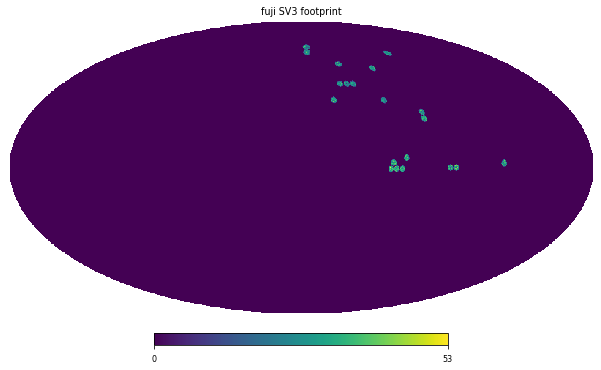

In [78]:
hp.mollview(footprint, rot = -85, cmap = 'viridis', title = 'fuji SV3 footprint')
plt.savefig("../figures/sv3_footprint.pdf", dpi = 400, bbox_inches = 'tight')

### Create training set

In [79]:
zcat_elg_complete = tmpdata[['TARGETID', 'TARGET_RA', 'TARGET_DEC', 
                             'SPECTYPE', 'rosette_number', 'SHAPE_R', "MAG_G", "MAG_R", "MAG_Z", 
                             'g-r', 'r-z', 'gfib', 'rfib', 'zfib', 'Z', 'bin_label']]

In [80]:
# ensure each rows are unique
len(zcat_elg_complete) - len(np.unique(np.array(zcat_elg_complete['TARGETID'])))

0

In [81]:
# mix up the rows
df = zcat_elg_complete.to_pandas()
df = df.sample(frac = 1, replace = False, random_state = 45)
df = df.reset_index(drop = True)
df.head()

,TARGETID,TARGET_RA,TARGET_DEC,SPECTYPE,rosette_number,SHAPE_R,MAG_G,MAG_R,MAG_Z,g-r,r-z,gfib,rfib,zfib,Z,bin_label
0,39627781780277554,184.362351,-0.289296,b'QSO',2.0,0.000000,23.411702,23.240456,22.839370,0.171246,0.401086,23.685067,23.513821,23.112735,1.846289,2
1,39632951842964517,253.022667,33.602912,b'GALAXY',14.0,0.000000,23.550719,23.761088,23.413711,-0.210370,0.347378,23.822195,24.032565,23.685187,1.486535,1
2,39628459885988840,195.275319,28.957184,b'GALAXY',4.0,0.869456,22.599111,22.336956,21.879165,0.262155,0.457791,23.815420,23.553264,23.095473,0.088913,2
3,39627818010674036,183.795197,1.166600,b'GALAXY',2.0,0.000000,23.319172,22.997021,22.329896,0.322151,0.667124,23.592388,23.270237,22.603112,1.164192,1
4,39627752176878562,219.784088,-1.377008,b'GALAXY',9.0,0.321595,23.548393,23.258626,22.334236,0.289766,0.924391,24.041600,23.751834,22.827443,0.903435,1


In [84]:
df.loc[(df.bin_label == 2), 'Z'] = -99 #set all bad redshifts to -99 to distinguish

In [85]:
df['Z'].max()

1.6198079210989067

Check the stats of per label

In [86]:
df.groupby('bin_label').count()#/df.groupby('bin_label').count()['r-z'].sum()

,TARGETID,TARGET_RA,TARGET_DEC,SPECTYPE,rosette_number,SHAPE_R,MAG_G,MAG_R,MAG_Z,g-r,r-z,gfib,rfib,zfib,Z
bin_label,,,,,,,,,,,,,,,
0,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840,14840
1,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287,262287
2,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114,78114


### split rosette into equal areas 

In [88]:
#split using mean of DEC 
tmptransformed = df.groupby("rosette_number").TARGET_DEC.transform(lambda x : x > x.mean()) 
df['half_rosetteID'] = 2*df.rosette_number + tmptransformed

In [89]:
#reorder 
df = df[['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'SPECTYPE', 'rosette_number', 'half_rosetteID', 
         'SHAPE_R', 'MAG_G', 'MAG_R', 'MAG_Z', 'g-r', 'r-z', 'gfib', 'rfib', 
         'zfib', 'Z', 'bin_label']]

#### check whether split worked
We take the first half of `rosette_number == 0` and then the second half, plotting them on the sky. We also overlay the mean DEC of the same rosette number and see if it is in the middle. 

In [90]:
tmpdf0 = df[df['half_rosetteID'] == 0]
tmpdf1 = df[df['half_rosetteID'] == 1]
tmpdecmean = df.groupby("rosette_number")['TARGET_DEC'].mean()[0]

Text(0, 0.5, 'RA')

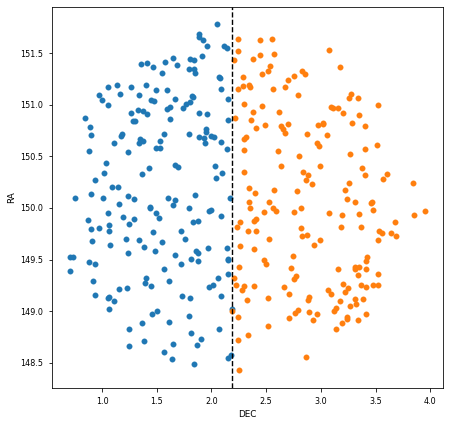

In [91]:
plt.figure(figsize=(7,7))
sample_rate = 50
plt.scatter(tmpdf0['TARGET_DEC'][::sample_rate], tmpdf0['TARGET_RA'][::sample_rate])
plt.scatter(tmpdf1['TARGET_DEC'][::sample_rate], tmpdf1['TARGET_RA'][::sample_rate])
plt.axvline(tmpdecmean, ls = '--', c = 'k')
plt.xlabel("DEC")
plt.ylabel("RA")

Save data file for future use

In [93]:
df.to_pickle("/global/cscratch1/sd/tanveerk/final_data_products/elgXplanck/fuji-elg-single-tomo.pkl")

In [8]:
df = pd.read_pickle("/pscratch/sd/t/tanveerk/final_data_products/elgXplanck/fuji-elg-single-tomo.pkl")

### Split into train-test sets

#### Randomly select rosettes for train and test
We want to split the rosettes into $32$ training and $8$ test tiles. We will use the principle of bootstrapping that has a better statistical behaviour than jackknifing. Our procedure is as follows:
- Split indices from 0 - 39 into sub-samples without replacement of test and training sets. We make this split at the beginning before boostrapping to ensure that the training and test rosettes are unique. 
- Next we sample the training and test indices sub-samples with the same size. This step is the boostrap step where we uniformly sample with replacement potential training and test rosettes. 
- This procedure is repeated $1000$ times to get a statistical distribution of the dndz. 

In [10]:
# define indices range and size of the sub-samples
idxrange = np.arange(20*2)
tst_sz = 4*2
trn_sz = 16*2

In [11]:
# split indices without replacement into train and test sub-samples.
rng = np.random.default_rng(20221109)
tmp_tst_rosetteID = rng.choice(idxrange, tst_sz, replace = False)
tmp_trn_rosetteID = np.setxor1d(idxrange, tmp_tst_rosetteID)
print(tmp_tst_rosetteID)
print(tmp_trn_rosetteID)

[17 31 32  6 10 39  2 20]
[ 0  1  3  4  5  7  8  9 11 12 13 14 15 16 18 19 21 22 23 24 25 26 27 28
 29 30 33 34 35 36 37 38]


In [25]:
# split into training and test
tst_set = df.loc[df['half_rosetteID'].isin(tmp_tst_rosetteID)]
trn_set = df.loc[df['half_rosetteID'].isin(tmp_trn_rosetteID)]

# shuffle 
tst_set = tst_set.sample(frac = 1).reset_index(drop=True)
trn_set = trn_set.sample(frac = 1).reset_index(drop=True)

Verify that train-test split worked as intended

We notice that in the test set there are two unique rosettes. We plot the footprint of the test set and indeed notice only two rosettes plotted, verifying our method.

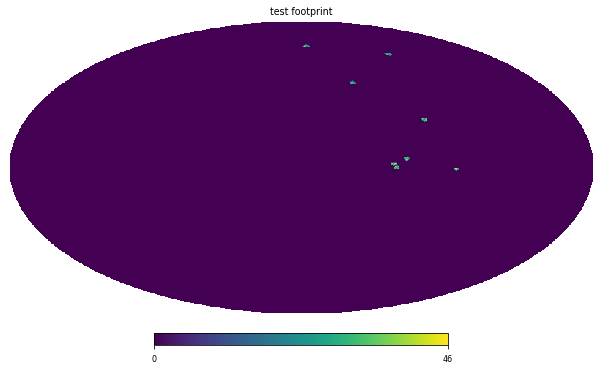

In [30]:
footprint = utilsAstro.hpixsum(nside = 512, ra = np.array(tst_set['TARGET_RA']), dec = np.array(tst_set['TARGET_DEC']))

hp.mollview(footprint, rot = -85, cmap = 'viridis', title = 'test footprint')

In [31]:
# verify that there is no overlap between training and test sets
np.intersect1d(trn_set['TARGETID'], tst_set['TARGETID'])

array([], dtype=int64)

Now we split the training and test into features and labels

In [38]:
# labels
y_tst = tst_set['bin_label']
y_trn = trn_set['bin_label']

# features
X_tst = tst_set.drop(['bin_label'], axis = 1)
X_trn = trn_set.drop(['bin_label'], axis = 1)

In [41]:
# stats for if objects were assigned labels at random, what the probabilities would be 

for i in range(len(np.unique(y_tst))):
    print(f"Baseline performance: for label {i} is {np.round(np.count_nonzero(y == i)/len(y), 2)}")

Baseline performance: for label 0 is 0.04
Baseline performance: for label 1 is 0.74
Baseline performance: for label 2 is 0.22


In [42]:
for i in range(len(np.unique(y_tst))):
    print(f"Baseline set: for label {i} is {(y == i).sum()}")
    print(f"Baseline training set: for label {i} is {(y_trn == i).sum()/len(y_trn) * 100}")
    print(f"Baseline test set: for label {i} is {(y_tst == i).sum()/len(y_tst) * 100}")

Baseline set: for label 0 is 14840
Baseline training set: for label 0 is 4.179580239671203
Baseline test set: for label 0 is 4.169088141690882
Baseline set: for label 1 is 262287
Baseline training set: for label 1 is 73.98213951252956
Baseline test set: for label 1 is 73.25169503251695
Baseline set: for label 2 is 78114
Baseline training set: for label 2 is 21.838280247799243
Baseline test set: for label 2 is 22.579216825792166


### Build sklearn pipeline with standardscalar and RandomForestClassifier

Build model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf=RandomForestClassifier(class_weight={0: 0.325, 1: 0.35, 2: 0.325},
                       max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=10, n_estimators=20, random_state=20221109) #based on randomsearchCV tuning 

pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', clf)])


Train model

In [61]:
pipeline.fit(X_trn.iloc[:,7:-1], y_trn)
y_prd = pipeline.predict(X_tst.iloc[:,7:-1])

Check feature importance

In [63]:
for kk in range(len(pipeline.steps[1][1].feature_importances_)):
    print(f"Feature: {X_trn.columns[7:-1][kk]}, importance: {pipeline.steps[1][1].feature_importances_[kk]}")
    print("---")

Feature: MAG_G, importance: 0.07313151070680472
---
Feature: MAG_R, importance: 0.07904461551670307
---
Feature: MAG_Z, importance: 0.14862056159299467
---
Feature: g-r, importance: 0.09515396488674456
---
Feature: r-z, importance: 0.2553418960721229
---
Feature: gfib, importance: 0.08195653740046574
---
Feature: rfib, importance: 0.08214186870843633
---
Feature: zfib, importance: 0.184609045115728
---


Check scores

In [64]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, precision_score, recall_score, classification_report
print(classification_report(y_tst, y_prd))

              precision    recall  f1-score   support

           0       0.53      0.05      0.09      3013
           1       0.80      0.92      0.86     52939
           2       0.57      0.39      0.46     16318

    accuracy                           0.77     72270
   macro avg       0.63      0.45      0.47     72270
weighted avg       0.74      0.77      0.74     72270



In [65]:
print(accuracy_score(y_tst, y_prd))
print(precision_score(y_tst, y_prd, average='macro'))
print(recall_score(y_tst, y_prd, average='macro'))

0.7650615746506157
0.6319651593010763
0.4528702797338648


Confusion Matrix

Text(0.5, 0, 'Predicted label')

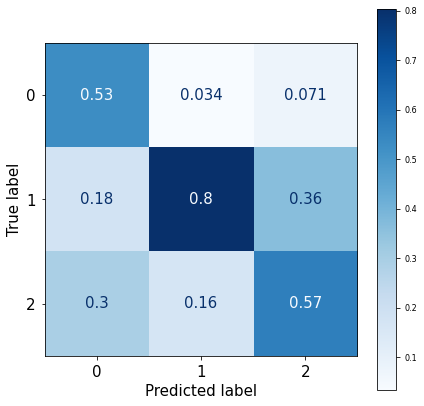

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_predictions(y_tst, y_prd, normalize='pred', cmap = 'Blues', ax = ax)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("True label", fontsize = 15)
plt.xlabel("Predicted label", fontsize = 15)

Save random forest model

In [40]:
import pickle 
pickle.dump(clf, open("/pscratch/sd/t/tanveerk/final_data_products/elgXplanck/fuji_RandomForestClassifier_single_tomo.pkl", 'wb'))

### Plot Redshift Distribution

% in tomo bin 2 with bad redshift: 0.16277539200684468


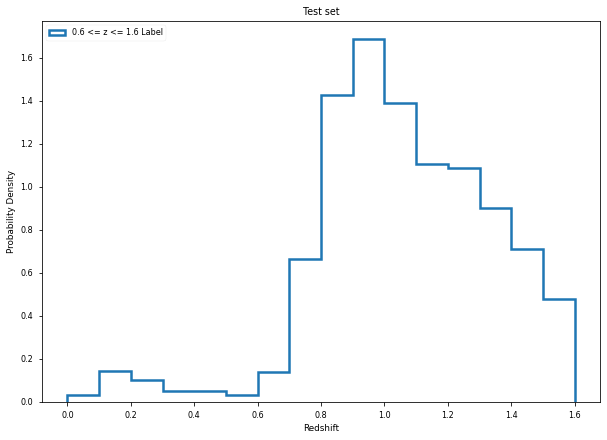

In [26]:
plt.figure(figsize=(10,7))
zrange = np.arange(0, 1.7, 0.1)

test_specz = X.iloc[indices_tst][y_prd == 1]['Z']
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "0.6 <= z <= 1.6 Label");

plt.legend(loc = 'upper left')
plt.title("Test set")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()

% in tomo bin 1 with bad redshift: 0.2878787878787879
% in tomo bin 2 with bad redshift: 0.14848830193738688


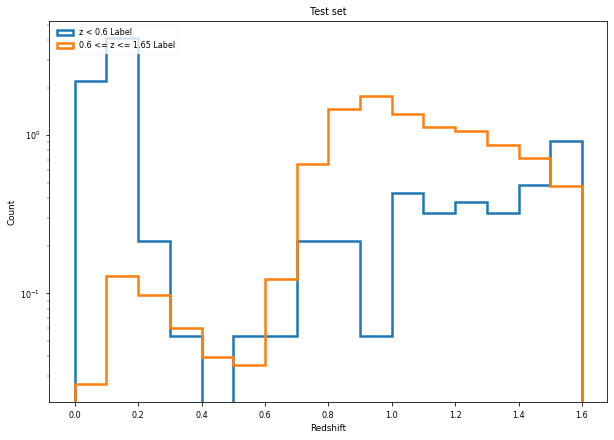

In [174]:
plt.figure(figsize=(10,7))
zrange = np.arange(0, 1.65, 0.1)

test_specz = X.iloc[indices_tst][y_prd == 0]['Z']
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "z < 0.6 Label");

test_specz = X.iloc[indices_tst][y_prd == 1]['Z']
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "0.6 <= z <= 1.65 Label");

#plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Test set")
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

In [24]:
from astropy.cosmology import Planck18
from astropy.constants import c

In [25]:
#plot CMB lensing kernel
def cmb_kernel(z):
    return 3/2 * Planck18.Om0/c * Planck18.H0**2/Planck18.H(z) * (1 + z) * Planck18.comoving_distance(z) * (1 - Planck18.comoving_distance(z)/Planck18.comoving_distance(1090))

In [58]:
bin_ledge = tst_1[1]
bin_mid = bin_ledge[:-1] + np.diff(bin_ledge)/2
bin_ledge = bin_ledge[:-1] #remove the rightmost edge to have same shape as bin_mid

tomo1_values = tst_1[0]
tomo2_values = tst_2[0]

#### Save model

In [42]:
import pickle
# now you can save it to a file
with open('/pscratch/sd/t/tanveerk/final_data_products/photoz_RF.pkl', 'wb') as f:
    pickle.dump(clf, f)

### Add exponential decay to the curve

In [27]:
# define decay constant function 
decay_const = lambda P0, area : P0/area

# define exponential decay; zr is the rightmost bin defined in the actual hist
tail_pz = lambda P0, area, z, zr : P0*np.exp(-(P0/area)*(z - zr))

In [28]:
# setup variables for plotting
bin_mid = tst_2[1][:-1] + np.diff(tst_2[1])/2
main_bad_percnt = (test_specz == -99).sum()/len(test_specz) # frac of predicted label 1 that are label 2 from the main training in this notebook

In [29]:
main_bad_percnt

0.16277539200684468

In [30]:
#specify extended range
zrange_hist = tst_2[1][:-1] + np.diff(tst_2[1])/2 #actual histogram bin centers 
zextend_max = 3 #max redshift we will estimate out to 
zrange_extend = np.arange(zrange_hist[-1], zextend_max, 0.1) #maintain same binning width
zrange_comb = np.concatenate((zrange_hist, zrange_extend[1:])) # full redshift bin center range 

def extended_pz(bad_percnt, dndz_curve):
    m = bad_percnt
    r = np.random.default_rng(20221109).uniform(0, m)
    normed_curve = dndz_curve * (1 - r)

    tail_curve = tail_pz(normed_curve[-1], r, zrange_extend, zrange_hist[-1])
    pz_comb = np.concatenate((normed_curve, tail_curve[1:]))

    return dndz_curve, normed_curve, tail_curve, pz_comb

In [31]:
_,_,_, pz_dist_extended = extended_pz(main_bad_percnt, tst_2[0]) 

In [32]:
# # delete the same element appearing twice 
# zrange_comb = np.delete(zrange_comb, 15) #15th and 16th elements are the same
# pz_dist_extended = np.delete(pz_dist_extended, 15)

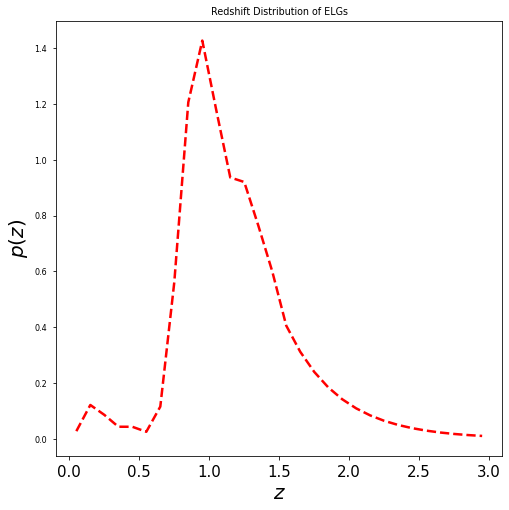

In [33]:
plt.figure(figsize=(8,8))
#for ii in range(1000):
#    plt.plot(zrange_comb, dndz_curves_extended[ii], alpha = 0.1, c = 'k', lw = 1)
plt.plot(zrange_comb, pz_dist_extended, alpha = 1, lw = 2.5, c = 'r', ls = '--')
plt.xlabel(r"$z$", fontsize = 20)
plt.ylabel(r"$p(z)$", fontsize = 20)
plt.savefig("../figures/dndz_main.pdf", bbox_inches = 'tight', dpi = 300)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.title("Redshift Distribution of ELGs")
plt.show()

Save redshift distribution for theory calculations.

In [34]:
tmpd = {'Redshift_mid' : zrange_comb,
    'pz' : pz_dist_extended} #dn/(dz * ddeg2)
pzdz = pd.DataFrame(tmpd)
pzdz.to_csv("../finalproducts/fuji_pz_single_tomo.csv")

## Redshift Uncertainty Distribution Estimation

In [35]:
dndz_curves = np.zeros((1000, 16))
bad_percnt = np.zeros(1000)

In [36]:
count = 0
for h in range(10):
    #tmparr = np.load("/pscratch/sd/t/tanveerk/photo-z/" + str(h) + "_normed.npy", allow_pickle=True)
    tmparr = np.load("/pscratch/sd/t/tanveerk/photo-z/" + str(h) +
                     "_normed.npy", allow_pickle=True) #for cori
    for i in range(10):
        for j in range(10):
            idx = h * 100 + i * 10 + j                
            #print(idx)
            dndz_curves[idx] = tmparr[i][j][0]
            bad_percnt[idx] = tmparr[i][j][2]
            count += 1

### Distribution of percentage of ELGs without redshift

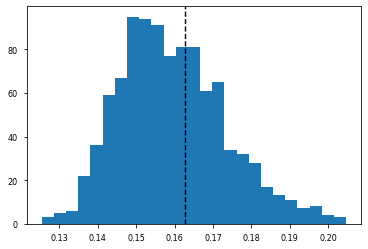

In [37]:
plt.hist(bad_percnt, bins = 25)
plt.axvline(main_bad_percnt, c = 'k', ls = '--') # where the main training lies

### Plot dndz curves and baseline curve

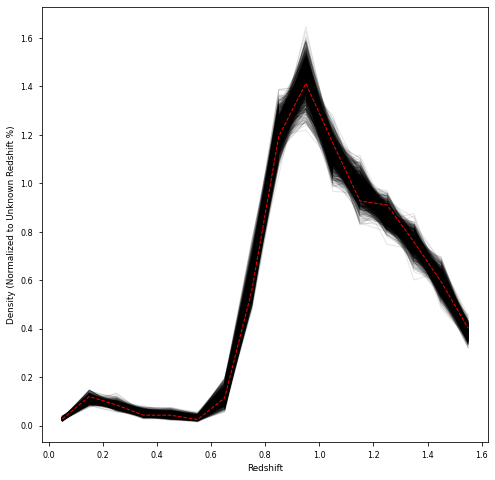

In [38]:
plt.figure(figsize=(8,8))


for ii in range(1000):
    plt.plot(bin_mid, dndz_curves[ii] * (1 - bad_percnt[ii]), alpha = 0.1, c = 'k', lw = 1)
plt.plot(bin_mid, tst_2[0] * (1 - main_bad_percnt), alpha = 1, lw = 1, c = 'r', ls = '--')
#plt.plot(bin_mid, pz_dist_extended[:len(bin_mid)], alpha = 1, lw = 1, c = 'y', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("Density (Normalized to Unknown Redshift %)")
plt.show()

Calculate photo-z covariance

In [55]:
cov = np.cov(dndz_curves.T)
err = np.std(dndz_curves.T, axis = 1, ddof = 1)
corr = cov/np.outer(err, err)

zranges = tst_2[1][:-1] + np.diff(tst_2[1])/2

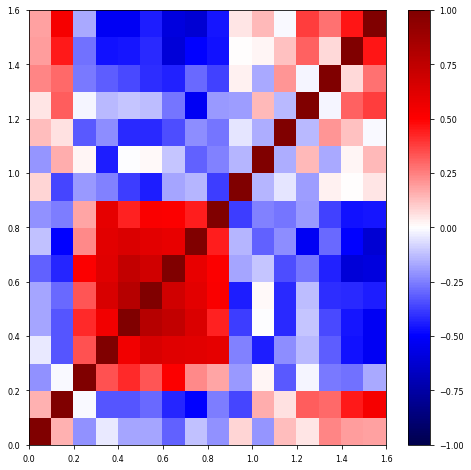

In [56]:
plt.figure(figsize=(8, 8))
plt.pcolor(zranges, zranges, corr, vmin = -1, vmax = +1, cmap = 'seismic')
plt.colorbar()

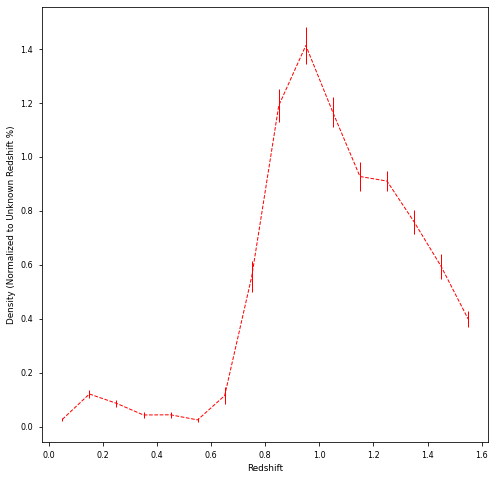

In [57]:
plt.figure(figsize=(8,8))
# for ii in range(1000):
#     plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, dndz_curves[ii] * (1 - bad_percnt[ii]), alpha = 0.1, c = 'k', lw = 1)
plt.errorbar(bin_mid, tst_2[0] * (1 - main_bad_percnt), yerr = err, alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("Density (Normalized to Unknown Redshift %)")
plt.show()

Signal-to-noise per redshift bin

In [58]:
yval = tst_2[0] * main_bad_percnt

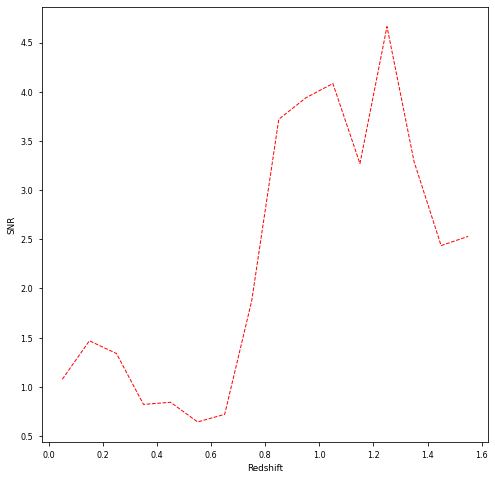

In [59]:
plt.figure(figsize=(8,8))
# for ii in range(1000):
#     plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, dndz_curves[ii] * (1 - bad_percnt[ii]), alpha = 0.1, c = 'k', lw = 1)
plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, yval/err, alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("SNR")
plt.show()

#### Add exponential decay to all the curves

In [39]:
#specify extended range
zrange_hist = tst_2[1][:-1] + np.diff(tst_2[1])/2 #actual histogram bin centers 
zextend_max = 3 #max redshift we will estimate out to 
zrange_extend = np.arange(zrange_hist[-1], zextend_max, 0.1) #maintain same binning width
zrange_comb = np.concatenate((zrange_hist, zrange_extend[1:])) # full redshift bin center range 

def extended_pz(idx):
    m = bad_percnt[idx]
    r = np.random.default_rng(20221109).uniform(0, m)
    normed_curve = dndz_curves[idx] * (1 - r)
    
    tail_curve = tail_pz(normed_curve[-1], r, zrange_extend, zrange_hist[-1])
    pz_comb = np.concatenate((normed_curve, tail_curve[1:]))
    
    return pz_comb

In [40]:
dndz_curves_extended = np.zeros((len(dndz_curves), len(zrange_comb)))

for jj in range(len(dndz_curves)):
    dndz_curves_extended[jj] = extended_pz(jj)

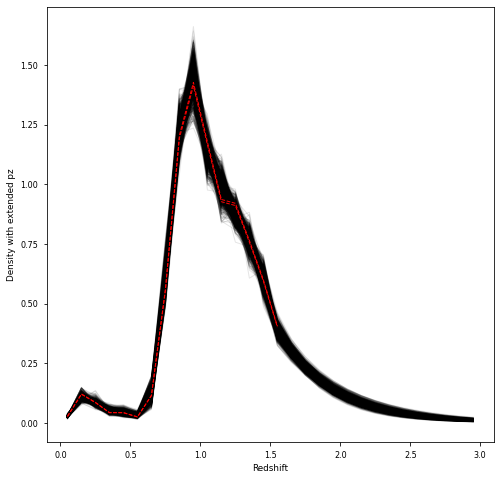

In [41]:
plt.figure(figsize=(8,8))
for ii in range(1000):
    plt.plot(zrange_comb, dndz_curves_extended[ii], alpha = 0.1, c = 'k', lw = 1)
plt.plot(bin_mid, tst_2[0] * (1 - main_bad_percnt), alpha = 1, lw = 1, c = 'r', ls = '--')
plt.plot(bin_mid, pz_dist_extended[:len(bin_mid)], alpha = 1, lw = 1, c = 'r', ls = '--')
#plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, tst_2[0] * (1 - (test_specz == -99).sum()/len(test_specz)), alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("Density with extended pz")
#plt.savefig("../plots/dndz_contour.pdf", bbox_inches = 'tight', dpi = 450)
plt.show()

In [42]:
#dict to save for use
dndz_final_dict = {}
dndz_final_dict['zrange'] = zrange_comb
dndz_final_dict['dndz'] = dndz_curves_extended

In [43]:
import pickle

# save dndz curves for usage
pickle.dump(dndz_final_dict, open("/pscratch/sd/t/tanveerk/final_data_products/elgXplanck/dndz_extended.p", "wb" ))
pickle.dump(dndz_final_dict, open("/global/homes/t/tanveerk/lselgsXplanck/finalproducts/dndz_extended.p", "wb" ))

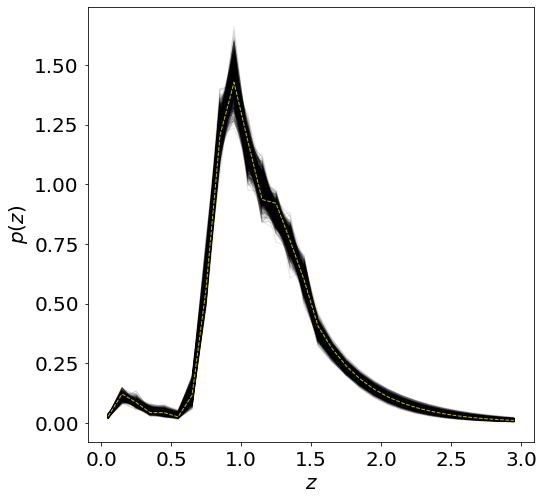

In [44]:
plt.figure(figsize=(8,8))

for ii in range(1000):
    plt.plot(zrange_comb, dndz_curves_extended[ii], alpha = 0.1, c = 'k', lw = 1)

plt.plot(zrange_comb, pz_dist_extended, alpha = 1, lw = 1, c = 'y', ls = '--')

plt.xlabel(r"$z$", fontsize = 20)
plt.ylabel(r"$p(z)$", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig("../figures/dndz_full.pdf", bbox_inches = 'tight', dpi = 450)
plt.show()

### Calculate extended $p(z)$ covariance

In [46]:
cov = np.cov(dndz_curves_extended.T)
err = np.std(dndz_curves_extended.T, axis = 1, ddof = 1)
corr = cov/np.outer(err, err)

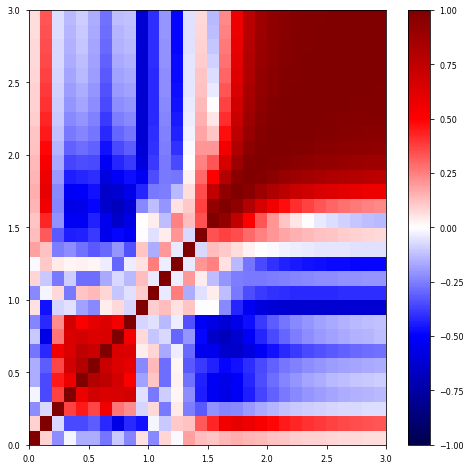

In [47]:
plt.figure(figsize=(8, 8))
plt.pcolor(zrange_comb, zrange_comb, corr, vmin = -1, vmax = +1, cmap = 'seismic')
plt.colorbar()

In [69]:
import astropy
import astropy.units as u

In [74]:
#plot CMB lensing kernel
c = astropy.constants.c

def cmb_kernel(z):
    kernel = 3/2 * Planck18.Om0/c * Planck18.H0**2/Planck18.H(z) * (1 + z) * \
Planck18.comoving_distance(z) * (1 - Planck18.comoving_distance(z)/Planck18.comoving_distance(1090))
    return kernel.to(u.km/u.km)

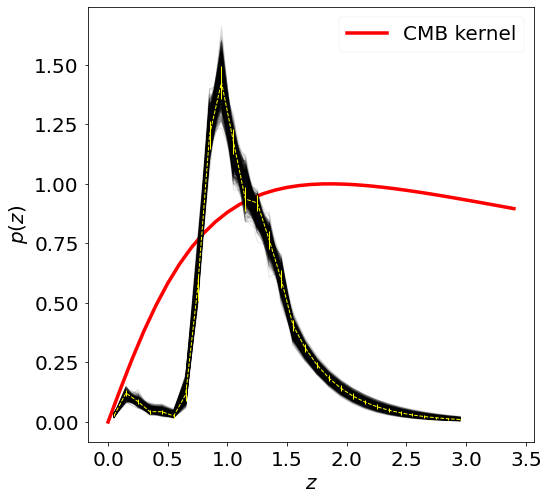

In [79]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(0, 3.5, 0.1), cmb_kernel(np.arange(0, 3.5, 0.1))/cmb_kernel(np.arange(0, 3.5, 0.1)).max(),
         label = 'CMB kernel', c = 'r', lw = 3.5)
for ii in range(1000):
    plt.plot(zrange_comb, dndz_curves_extended[ii], alpha = 0.1, c = 'k', lw = 1)

plt.errorbar(zrange_comb, pz_dist_extended, yerr = err, alpha = 1, lw = 1, c = 'yellow', ls = '--')
plt.xlabel(r"$z$", fontsize = 20)
plt.ylabel(r"$p(z)$", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc = 'best', fontsize = 20)
plt.savefig("../figures/dndz_full.pdf", bbox_inches = 'tight', dpi = 450)
plt.show()